In [1]:
import os
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [2]:
# font for korean
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['font.family'] = 'NanumGothicCoding'

# font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
# mpl.rcParams['axes.unicode_minus'] = False
# plt.rcParams["font.family"] = 'NanumGothicCoding-Bold'

In [3]:
target_col = '총유기탄소'
# target_col = '클로로필-a'
#target_col = '수온'

input_step = 24*7
OUT_STEPS = 24

MAX_EPOCHS = 200

In [4]:
val_performance = {}
performance = {}
multi_val_performance = {}
multi_performance = {}

In [5]:
df = pd.read_excel("./data/8/1.xlsx")
# df = pd.read_csv("./data/8/df1.csv", encoding='utf-8-sig')

In [6]:
date_time = pd.to_datetime(df.pop('측정날짜'), format='%Y.%m.%d %H:%M:%S', utc=True )
# date_time = pd.to_datetime(df['측정날짜'], format='%Y.%m.%d %H:%M:%S')
# print(date_time)
# print(df.head())

timestamp_s = date_time.map(datetime.datetime.timestamp)

day = 24*60*60
week = day * 7
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
df['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

KeyError: '측정날짜'

In [ ]:
plt.plot(np.array(df['Day sin'])[:24])
plt.plot(np.array(df['Day cos'])[:24])

In [ ]:
plt.plot(np.array(df['Year sin'])[:24*356])
plt.plot(np.array(df['Year cos'])[:24*356])

In [7]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [8]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [9]:
train_df

,수온,수소이온농도,전기전도도,용존산소,탁도,총유기탄소,총질소,총인,클로로필-a,미생물_독성지수,Day sin,Day cos,Year sin,Year cos
0,-1.124839,0.727512,-0.384094,1.454785,-0.265323,-0.859753,-2.558061,-0.153602,-0.379552,0.269462,-1.439533,-0.046546,1.131723,0.606452
1,-1.151378,0.727512,-0.384094,1.399731,-0.265323,-0.859753,-2.583812,-0.153602,-0.361220,-2.672698,-1.391464,0.320896,1.132107,0.605482
2,-1.151378,0.727512,-0.384094,1.399731,-0.265323,-0.859753,-2.554383,-0.153602,-0.361220,-0.272515,-1.250534,0.663296,1.132490,0.604512
3,-1.151378,0.727512,-0.384094,1.399731,-0.265323,-0.859753,-2.598527,-0.484692,-0.379552,2.747070,-1.026347,0.957322,1.132873,0.603542
4,-1.164648,0.727512,-0.384094,1.399731,-0.265323,-0.563912,-2.348376,-0.153602,-0.397884,0.424312,-0.734180,1.182937,1.133255,0.602571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7332,0.520613,0.094464,-0.916401,-0.141790,-0.183775,0.323608,-1.730356,-1.477964,-0.232894,0.656588,-1.026347,0.957322,0.673524,-1.150530
7333,0.520613,0.094464,-0.916401,-0.196845,-0.167465,0.323608,-1.851753,-1.146873,-0.251226,2.437369,-0.734180,1.182937,0.672725,-1.151150
7334,0.507344,0.094464,-0.916401,-0.196845,-0.183775,0.027768,-1.748749,-1.477964,-0.242060,-1.588745,-0.393944,1.324764,0.671926,-1.151770
7335,0.507344,-0.222060,-0.916401,-0.306953,-0.167465,0.323608,-1.678854,-1.146873,-0.251226,0.424312,-0.028827,1.373138,0.671126,-1.152388


In [10]:
# Data Window
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [11]:
# Data 분할
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels


In [12]:
def plot(self, model=None, plot_col=target_col, max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')
  plt.show()

In [13]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

In [14]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

In [15]:
WindowGenerator.split_window = split_window
WindowGenerator.plot = plot
WindowGenerator.make_dataset = make_dataset

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [16]:
multi_window = WindowGenerator(input_width=input_step,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS, 
                              label_columns=[target_col])

In [17]:
multi_window

Total window size: 192
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167]
Label indices: [168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191]
Label column name(s): ['총유기탄소']

In [18]:
def compile_and_fit(model, window, patience=3):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                         min_lr=1e-4, patience=0, verbose=1)

  adam = tf.keras.optimizers.Adam(learning_rate=0.1)

  # model.compile(loss=tf.losses.MeanSquaredError(),
  #               optimizer=tf.optimizers.Adam(),
  #               metrics=[tf.metrics.MeanAbsoluteError()])

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=adam,
                metrics=[tf.metrics.MeanAbsoluteError()])

#   history = model.fit(window.train, epochs=MAX_EPOCHS,
#                       validation_data=window.val,
#                       callbacks=[early_stopping, reduce_lr])

  history = model.fit(window.train, epochs=MAX_EPOCHS, batch_size = 256,
                          validation_data=window.val)

  return history

In [19]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])


history = compile_and_fit(multi_lstm_model, multi_window, 10)


Epoch 1/200
224/224 [==============================] - 1s 7ms/step - loss: 0.2279 - mean_absolute_error: 0.3113 - val_loss: 0.2752 - val_mean_absolute_error: 0.4251
Epoch 2/200
224/224 [==============================] - 1s 5ms/step - loss: 0.1253 - mean_absolute_error: 0.2343 - val_loss: 0.2472 - val_mean_absolute_error: 0.3727
Epoch 3/200
224/224 [==============================] - 1s 5ms/step - loss: 0.1235 - mean_absolute_error: 0.2345 - val_loss: 0.2542 - val_mean_absolute_error: 0.3847
Epoch 4/200
224/224 [==============================] - 1s 5ms/step - loss: 0.1180 - mean_absolute_error: 0.2317 - val_loss: 0.3094 - val_mean_absolute_error: 0.4209
Epoch 5/200
224/224 [==============================] - 1s 5ms/step - loss: 0.1148 - mean_absolute_error: 0.2294 - val_loss: 0.3248 - val_mean_absolute_error: 0.4358
Epoch 6/200
224/224 [==============================] - 1s 5ms/step - loss: 0.1104 - mean_absolute_error: 0.2272 - val_loss: 0.4392 - val_mean_absolute_error: 0.5089
Epoch 7/20

224/224 [==============================] - 1s 5ms/step - loss: 0.1172 - mean_absolute_error: 0.2310 - val_loss: 0.4016 - val_mean_absolute_error: 0.4605
Epoch 51/200
224/224 [==============================] - 1s 5ms/step - loss: 0.1142 - mean_absolute_error: 0.2294 - val_loss: 0.4175 - val_mean_absolute_error: 0.4709
Epoch 52/200
224/224 [==============================] - 1s 5ms/step - loss: 0.1095 - mean_absolute_error: 0.2257 - val_loss: 0.3886 - val_mean_absolute_error: 0.4600
Epoch 53/200
224/224 [==============================] - 1s 5ms/step - loss: 0.1111 - mean_absolute_error: 0.2285 - val_loss: 0.3630 - val_mean_absolute_error: 0.4319
Epoch 54/200
224/224 [==============================] - 1s 5ms/step - loss: 0.1108 - mean_absolute_error: 0.2319 - val_loss: 0.3605 - val_mean_absolute_error: 0.4382
Epoch 55/200
224/224 [==============================] - 1s 5ms/step - loss: 0.1140 - mean_absolute_error: 0.2302 - val_loss: 0.3544 - val_mean_absolute_error: 0.4611
Epoch 56/200
224/

224/224 [==============================] - 1s 5ms/step - loss: 0.1267 - mean_absolute_error: 0.2487 - val_loss: 0.3302 - val_mean_absolute_error: 0.4678
Epoch 100/200
224/224 [==============================] - 1s 5ms/step - loss: 0.1463 - mean_absolute_error: 0.2644 - val_loss: 0.2950 - val_mean_absolute_error: 0.4288
Epoch 101/200
224/224 [==============================] - 1s 5ms/step - loss: 0.1388 - mean_absolute_error: 0.2595 - val_loss: 0.2940 - val_mean_absolute_error: 0.4266
Epoch 102/200
224/224 [==============================] - 1s 5ms/step - loss: 0.1379 - mean_absolute_error: 0.2585 - val_loss: 0.2883 - val_mean_absolute_error: 0.4247
Epoch 103/200
224/224 [==============================] - 1s 5ms/step - loss: 0.1423 - mean_absolute_error: 0.2611 - val_loss: 0.2986 - val_mean_absolute_error: 0.4350
Epoch 104/200
224/224 [==============================] - 1s 5ms/step - loss: 0.1374 - mean_absolute_error: 0.2540 - val_loss: 0.2857 - val_mean_absolute_error: 0.4174
Epoch 105/20

224/224 [==============================] - 1s 5ms/step - loss: 0.1243 - mean_absolute_error: 0.2419 - val_loss: 0.3364 - val_mean_absolute_error: 0.4687
Epoch 149/200
224/224 [==============================] - 1s 5ms/step - loss: 0.1133 - mean_absolute_error: 0.2306 - val_loss: 0.3586 - val_mean_absolute_error: 0.4829
Epoch 150/200
224/224 [==============================] - 1s 5ms/step - loss: 0.1131 - mean_absolute_error: 0.2307 - val_loss: 0.3562 - val_mean_absolute_error: 0.4787
Epoch 151/200
224/224 [==============================] - 1s 5ms/step - loss: 0.1131 - mean_absolute_error: 0.2312 - val_loss: 0.3605 - val_mean_absolute_error: 0.4841
Epoch 152/200
224/224 [==============================] - 1s 5ms/step - loss: 0.1105 - mean_absolute_error: 0.2276 - val_loss: 0.3652 - val_mean_absolute_error: 0.4879
Epoch 153/200
224/224 [==============================] - 1s 5ms/step - loss: 0.1092 - mean_absolute_error: 0.2261 - val_loss: 0.3566 - val_mean_absolute_error: 0.4796
Epoch 154/20

224/224 [==============================] - 1s 5ms/step - loss: 0.1152 - mean_absolute_error: 0.2356 - val_loss: 0.4430 - val_mean_absolute_error: 0.5270
Epoch 198/200
224/224 [==============================] - 1s 5ms/step - loss: 0.1189 - mean_absolute_error: 0.2379 - val_loss: 0.4646 - val_mean_absolute_error: 0.5175
Epoch 199/200
224/224 [==============================] - 1s 5ms/step - loss: 0.1192 - mean_absolute_error: 0.2377 - val_loss: 0.3955 - val_mean_absolute_error: 0.4978
Epoch 200/200
224/224 [==============================] - 1s 5ms/step - loss: 0.1113 - mean_absolute_error: 0.2300 - val_loss: 0.4175 - val_mean_absolute_error: 0.5131


findfont: Font family ['NanumGothicCoding'] not found. Falling back to DejaVu Sans.


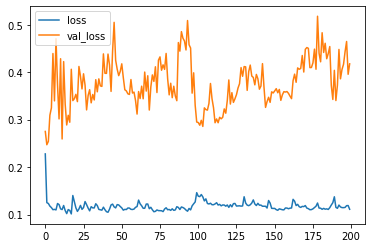

In [20]:
# print(history.history['loss'])
# print(history.history['val_loss'])

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


60/60 [==============================] - 0s 2ms/step - loss: 0.4175 - mean_absolute_error: 0.5131


/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 52509 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 53444 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/cjinw/cjinw_work/env-tf-2/lib/pyth

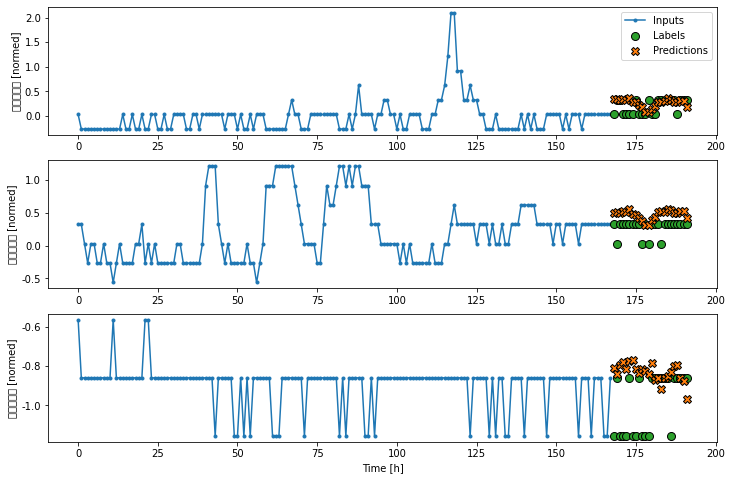

In [21]:
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)